**Цель: Изучить применение методов по поиску выбросов в данных, попрактиковаться в обработке экстремальных значений.**

**Описание задания: В домашнем задании нужно решить задачу классификации типа стекол. Данные для обучения моделей можно скачать с сайта. Целевая переменная – тип стекла «Type». Остальные признаки описывают химические элементы в составе материала. Датасет нужно исследовать на наличие выбросов, провести EDA.**

In [88]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest

# 1. Получите данные и загрузите их в рабочую среду (Jupyter Notebook или другую).

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/W1llAnn/file_for_hwork/main/glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1




---



---



---



# 2. Проведите первичный анализ.
*   Проверьте количество записей для каждого класса. Сделайте вывод.

In [3]:
df.shape

(214, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Поспотрим на целевую переменную:

In [5]:
df['Type'].unique()

array([1, 2, 3, 5, 6, 7])

In [6]:
print(f'Всего строк с Type = 1: {len(df[df.Type == 1])}')
print(f'Всего строк с Type = 2: {len(df[df.Type == 2])}')
print(f'Всего строк с Type = 3: {len(df[df.Type == 3])}')
print(f'Всего строк с Type = 5: {len(df[df.Type == 5])}')
print(f'Всего строк с Type = 6: {len(df[df.Type == 6])}')
print(f'Всего строк с Type = 7: {len(df[df.Type == 7])}')

Всего строк с Type = 1: 70
Всего строк с Type = 2: 76
Всего строк с Type = 3: 17
Всего строк с Type = 5: 13
Всего строк с Type = 6: 9
Всего строк с Type = 7: 29


*Всего записей 214. Пропусков нет, все данные имеют числовой формат. В целевой переменной 6 видов стекла, каждый из них - отдельный класс*



---



---



---



# 3. Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.

In [7]:
X = df.drop(['Type'], axis=1)
y = df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)



---



---



---



# 4. Обучите модель дерева решений RandomForestClassifier на обучающем множестве

In [13]:
model_1 = DecisionTreeClassifier(random_state=1)

model_1.fit(X_train, y_train)
pred_train_1 = model_1.predict(X_train)
pred_test_1 = model_1.predict(X_test)


*Модель обучена, перейдем к оценке качества*



---



---



---



# 5. Для тестового множества предскажите тип стекла и сравните с истинным значением, посчитав точность предсказания модели (accuracy).

In [14]:
print('balanced_accuracy_score')
print(f'Качество на обучающей выборке: {balanced_accuracy_score(y_train, pred_train_1)}')
print(f'Качество на валидационной выборке: {balanced_accuracy_score(y_test, pred_test_1)}')

balanced_accuracy_score
Качество на обучающей выборке: 1.0
Качество на валидационной выборке: 0.8063492063492063


In [15]:
print('accuracy_score')
print(f'Качество на обучающей выборке: {accuracy_score(y_train, pred_train_1)}')
print(f'Качество на валидационной выборке: {accuracy_score(y_test, pred_test_1)}')

accuracy_score
Качество на обучающей выборке: 1.0
Качество на валидационной выборке: 0.6976744186046512


*Если смотреть сбалансированный показатель точности (balanced_accuracy_score), то показатель 0,806 можно считать неплохим результатом, но мы все-таки будем опираться на оценку точности классификации (accuracy_score), а она показывает результат 0,698. Хотелось бы его повысить*



---



---



---



# 6. Обработайте выбросы в данных.
*   изуализируйте распределение значений для каждой переменной. Можно использовать функции sns.boxplot, sns.distplot. Есть ли признаки с нормальным распределением?
*   Исследуйте признаки на выбросы несколькими способами.
*   Удалите выбросы. Посчитайте процент удаленных записей от общего числа записей для каждого класса.

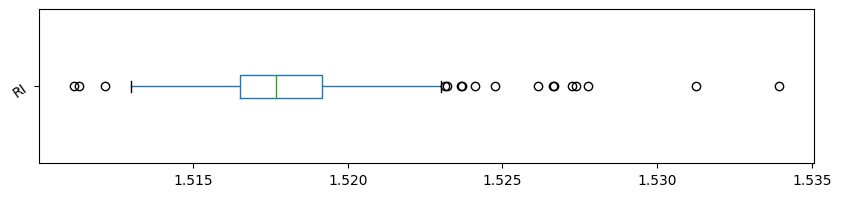

In [42]:
boxplot = df.boxplot(grid=False, column=['RI'],figsize=(10,2), vert=False, rot=35, fontsize=10)

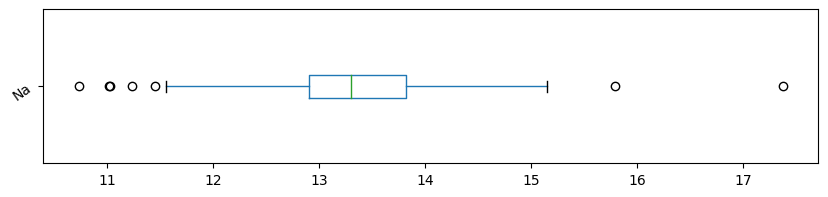

In [43]:
boxplot = df.boxplot(grid=False, column=['Na'],figsize=(10,2), vert=False, rot=35, fontsize=10)

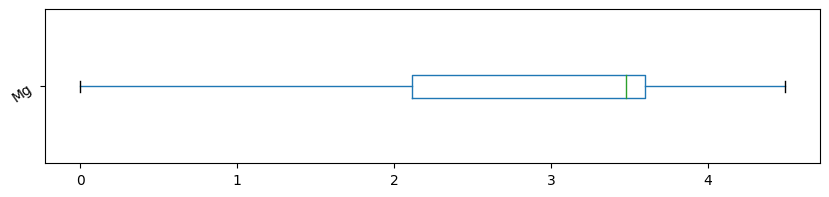

In [44]:
boxplot = df.boxplot(grid=False, column=['Mg'],figsize=(10,2), vert=False, rot=35, fontsize=10)

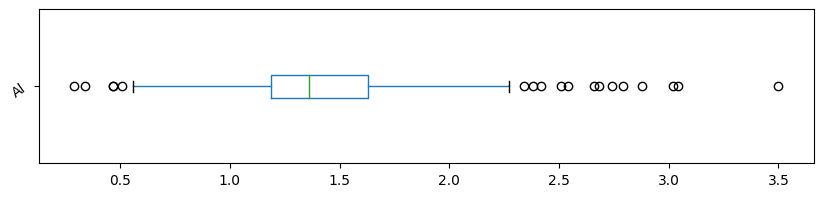

In [45]:
boxplot = df.boxplot(grid=False, column=['Al'],figsize=(10,2), vert=False, rot=35, fontsize=10)

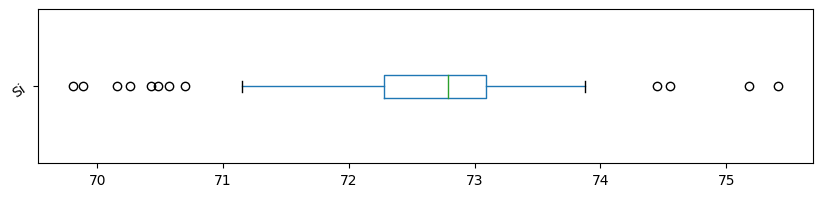

In [46]:
boxplot = df.boxplot(grid=False, column=['Si'],figsize=(10,2), vert=False, rot=35, fontsize=10)

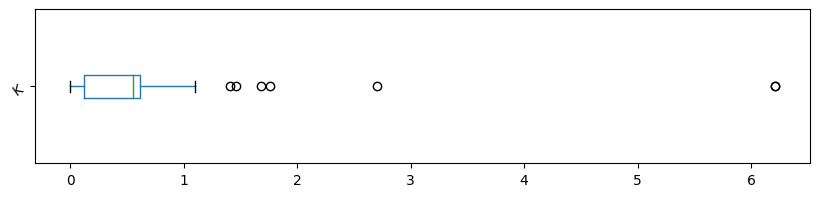

In [47]:
boxplot = df.boxplot(grid=False, column=['K'],figsize=(10,2), vert=False, rot=35, fontsize=10)

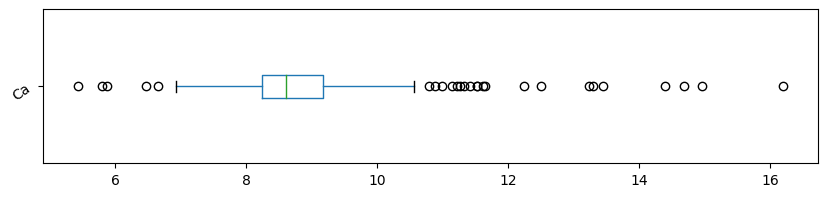

In [48]:
boxplot = df.boxplot(grid=False, column=['Ca'],figsize=(10,2), vert=False, rot=35, fontsize=10)

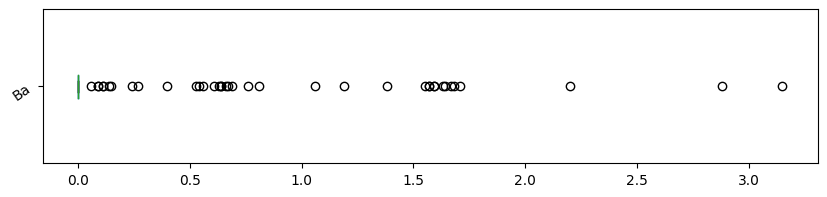

In [49]:
boxplot = df.boxplot(grid=False, column=['Ba'],figsize=(10,2), vert=False, rot=35, fontsize=10)

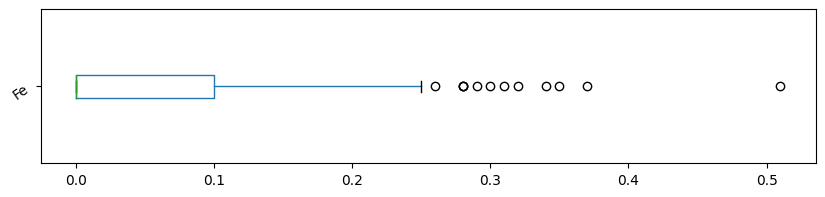

In [50]:
boxplot = df.boxplot(grid=False, column=['Fe'],figsize=(10,2), vert=False, rot=35, fontsize=10)

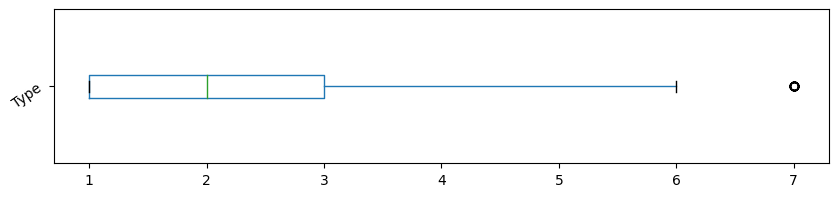

In [51]:
boxplot = df.boxplot(grid=False, column=['Type'],figsize=(10,2), vert=False, rot=35, fontsize=10)

*Если посмотреть на "ящики с усами" (boxplot) мы видим выбросы в следующих колонках: RI, Na, Al, Si, K, Ca, Ba, Fe, и даже в Type значение 7 определяется как выброс*

А что если посмотреть выбросы, учитывая Type

<Axes: xlabel='Type', ylabel='RI'>

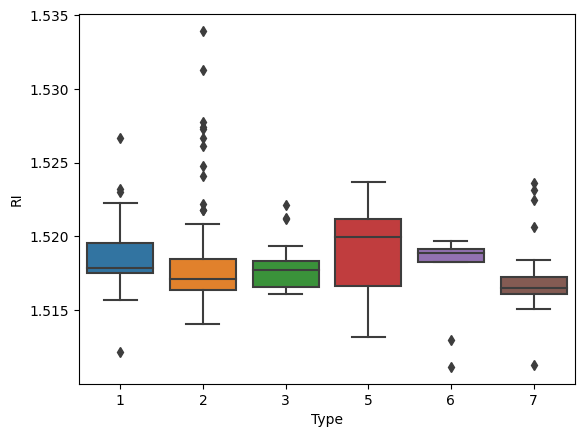

In [78]:
sns.boxplot(x=df['Type'], y=df['RI'], data=df)

<Axes: xlabel='Type', ylabel='Na'>

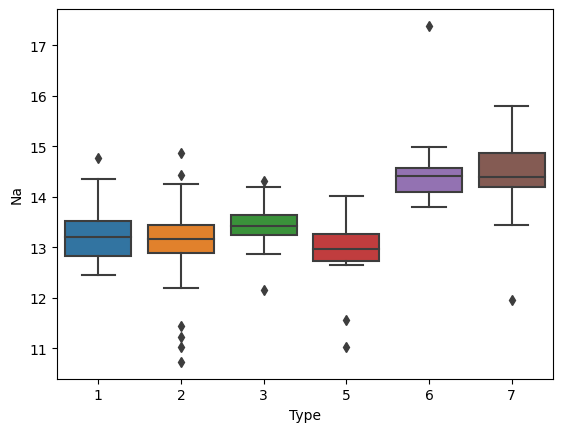

In [79]:
sns.boxplot(x=df['Type'], y=df['Na'], data=df)

<Axes: xlabel='Type', ylabel='Mg'>

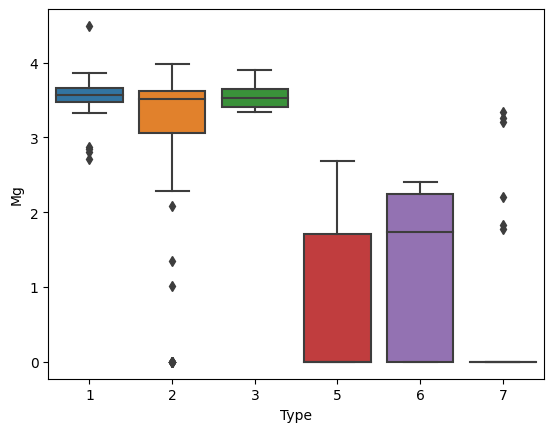

In [80]:
sns.boxplot(x=df['Type'], y=df['Mg'], data=df)

<Axes: xlabel='Type', ylabel='Al'>

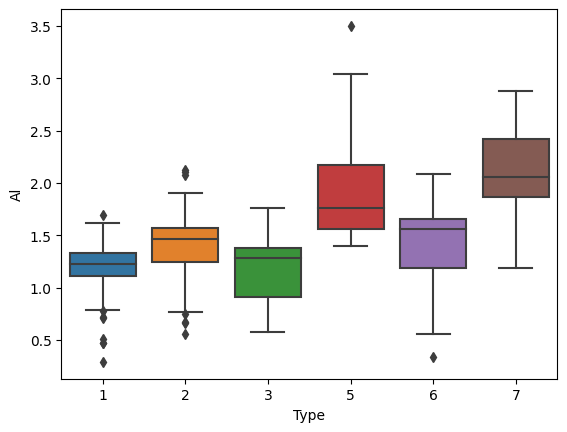

In [81]:
sns.boxplot(x=df['Type'], y=df['Al'], data=df)

<Axes: xlabel='Type', ylabel='Si'>

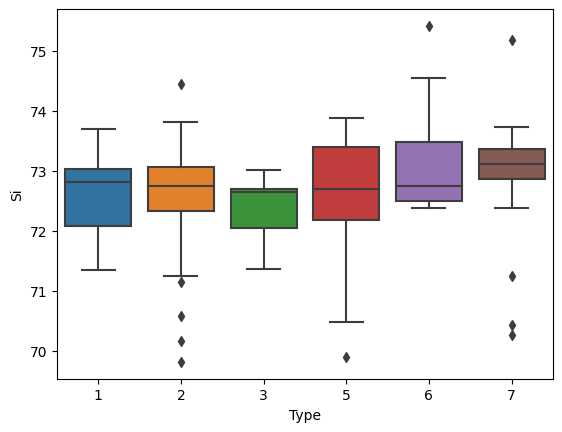

In [82]:
sns.boxplot(x=df['Type'], y=df['Si'], data=df)

<Axes: xlabel='Type', ylabel='K'>

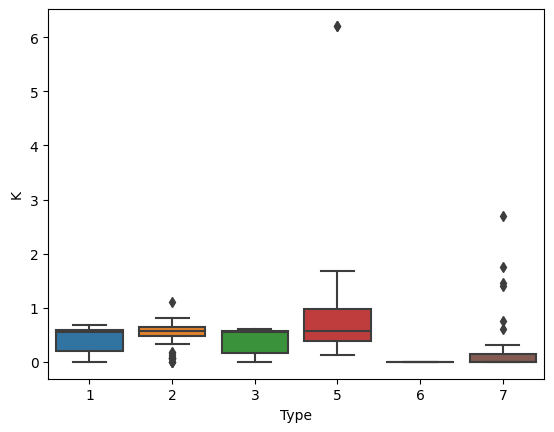

In [83]:
sns.boxplot(x=df['Type'], y=df['K'], data=df)

<Axes: xlabel='Type', ylabel='Ca'>

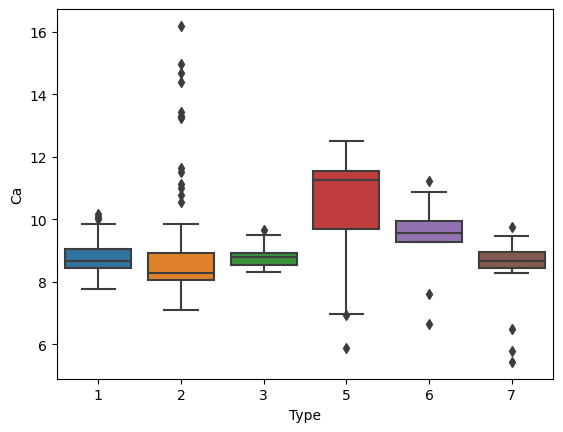

In [84]:
sns.boxplot(x=df['Type'], y=df['Ca'], data=df)

<Axes: xlabel='Type', ylabel='Ba'>

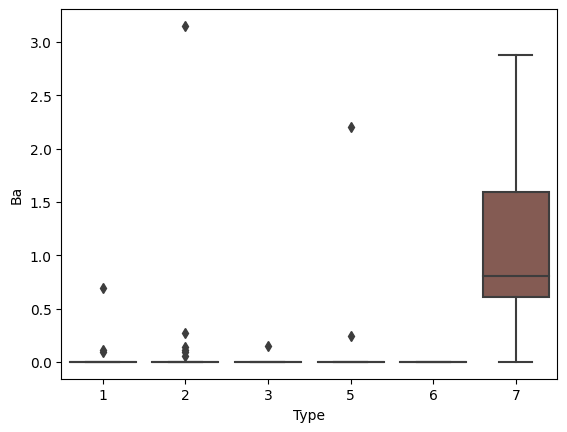

In [85]:
sns.boxplot(x=df['Type'], y=df['Ba'], data=df)

<Axes: xlabel='Type', ylabel='Fe'>

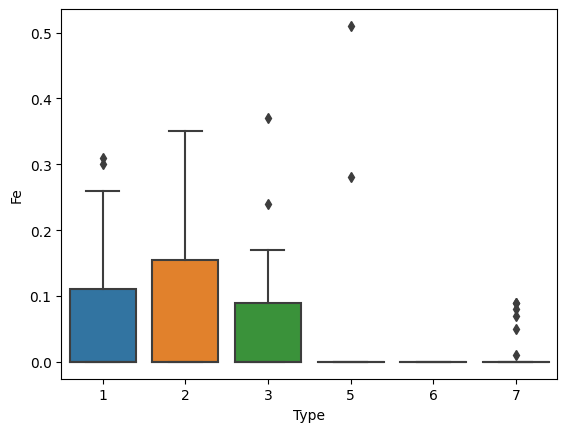

In [86]:
sns.boxplot(x=df['Type'], y=df['Fe'], data=df)

*По таким графикам мы уже видим чуть больше, и точнее понимаем какие выбросы есть у разных типов стекла*

**Попробуем использовать IsolationForest**

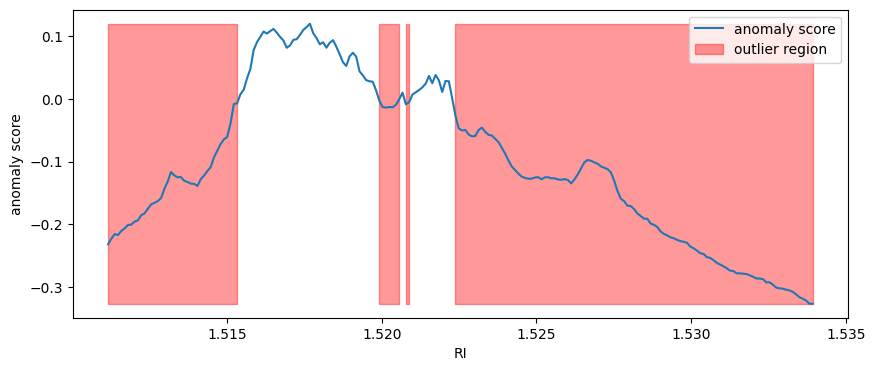

In [65]:
isolation_forest = IsolationForest(random_state=0).fit(df['RI'].values.reshape(-1, 1))
xx = np.linspace(df['RI'].min(), df['RI'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='anomaly score')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score),
                 where=outlier==-1, color='r',
                 alpha=.4, label='outlier region')
plt.legend()
plt.ylabel('anomaly score')
plt.xlabel('RI')
plt.show();


Или метод межквартильного диапазона:

In [73]:
def outlier_treatment(datacolumn):
 sorted(datacolumn)
 Q1,Q3 = np.percentile(datacolumn , [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

In [76]:
lowerbound,upperbound = outlier_treatment(df["RI"])
df[(df.RI < lowerbound) | (df.RI > upperbound)]

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
47,1.52667,13.99,3.70,0.71,71.57,0.02,9.82,0.00,0.10,1
50,1.52320,13.72,3.72,0.51,71.75,0.09,10.06,0.00,0.16,1
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.00,0.31,1
103,1.52725,13.80,3.15,0.66,70.57,0.08,11.64,0.00,0.00,2
104,1.52410,13.83,2.90,1.17,71.15,0.08,10.79,0.00,0.00,2
105,1.52475,11.45,0.00,1.88,72.19,0.81,13.24,0.00,0.34,2
106,1.53125,10.73,0.00,2.10,69.81,0.58,13.30,3.15,0.28,2
107,1.53393,12.30,0.00,1.00,70.16,0.12,16.19,0.00,0.24,2
110,1.52664,11.23,0.00,0.77,73.21,0.00,14.68,0.00,0.00,2
111,1.52739,11.02,0.00,0.75,73.08,0.00,14.96,0.00,0.00,2


Все эти строки определяются как выбросы в колонке RI

А если сначала посмотреть матрицу ошибок первой модели, обученной на выборке без изменений, и потом отпрасывать выбросы:

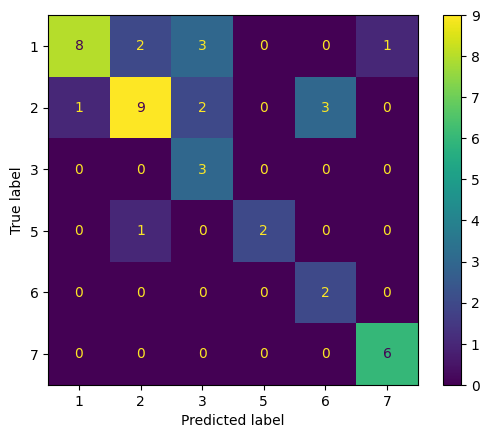

In [89]:
cm = confusion_matrix(y_test, pred_test_1, labels=model_1.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model_1.classes_)
disp.plot()
plt.show()

Наблюдение: Модель чаще ошибалась в предсказаниях, связанных с 1 и 2 классами стекла.

И на boxplot, которые мы разделили по типу стекла мы можем увидеть что большое количество выбросов как раз в типе стекла 1 и 2

**УДАЛИМ ВЫБРОСЫ**

Посмотрим все значения по квантилям:

In [126]:
print(f'RI lowerbound,upperbound {outlier_treatment(df["RI"])}')
print(f'Na lowerbound,upperbound {outlier_treatment(df["Na"])}')
print(f'Mg lowerbound,upperbound {outlier_treatment(df["Mg"])}')
print(f'Al lowerbound,upperbound {outlier_treatment(df["Al"])}')
print(f'Si lowerbound,upperbound {outlier_treatment(df["Si"])}')
print(f'K lowerbound,upperbound {outlier_treatment(df["K"])}')
print(f'Ca lowerbound,upperbound {outlier_treatment(df["Ca"])}')
print(f'Ba lowerbound,upperbound {outlier_treatment(df["Ba"])}')
print(f'Fe lowerbound,upperbound {outlier_treatment(df["Fe"])}')

RI lowerbound,upperbound (1.5125700000000002, 1.52311)
Na lowerbound,upperbound (11.531250000000004, 15.201249999999998)
Mg lowerbound,upperbound (-0.11250000000000071, 5.827500000000001)
Al lowerbound,upperbound (0.53, 2.29)
Si lowerbound,upperbound (71.06875, 74.29875000000001)
K lowerbound,upperbound (-0.6087499999999999, 1.34125)
Ca lowerbound,upperbound (6.841250000000001, 10.57125)
Ba lowerbound,upperbound (0.0, 0.0)
Fe lowerbound,upperbound (-0.15000000000000002, 0.25)


Создадим копию наших данных

In [263]:
df_clean_1 = df[
    (df['RI'] < 1.52) &
    (df['RI'] > 1.51) &
    (df['Na'] < 15.2) &
    (df['Na'] > 11.53) &
    (df['Al'] < 2.29) &
    (df['Al'] > 0.53) &
    (df['Si'] < 74.3) &
    (df['Si'] > 71.1) &
    (df['K'] < 1.34) &
    (df['K'] > -0.61) &
    (df['Ca'] < 10.57) &
    (df['Ca'] > 6.84) &
    (df['Fe'] > -0.15) &
    (df['Fe'] < 0.25)
]

In [264]:
df_clean_1.shape

(137, 10)

У нас получился датафрейм на 137 записей из 214 изначальных. Процент удаленных записей для каждого класса:

In [265]:
print(f'Type 1 {round(100 * (len(df[df.Type == 1]) - len(df_clean_1[df_clean_1.Type == 1]))/len(df[df.Type == 1]), 3)} %')
print(f'Type 2 {round(100 * (len(df[df.Type == 2]) - len(df_clean_1[df_clean_1.Type == 2]))/len(df[df.Type == 2]), 3)} %')
print(f'Type 3 {round(100 * (len(df[df.Type == 3]) - len(df_clean_1[df_clean_1.Type == 3]))/len(df[df.Type == 3]), 3)} %')
print(f'Type 5 {round(100 * (len(df[df.Type == 5]) - len(df_clean_1[df_clean_1.Type == 5]))/len(df[df.Type == 5]), 3)} %')
print(f'Type 6 {round(100 * (len(df[df.Type == 6]) - len(df_clean_1[df_clean_1.Type == 6]))/len(df[df.Type == 6]), 3)} %')
print(f'Type 7 {round(100 * (len(df[df.Type == 7]) - len(df_clean_1[df_clean_1.Type == 7]))/len(df[df.Type == 7]), 3)} %')

Type 1 28.571 %
Type 2 27.632 %
Type 3 17.647 %
Type 5 84.615 %
Type 6 44.444 %
Type 7 62.069 %




---



---



---



# 7. Повторите п. 4, п. 5.

Обучим модель на новых данных:

In [266]:
X_clean_1 = df_clean_1.drop(['Type'], axis=1)
y_clean_1 = df_clean_1['Type']

X_clean_train_1, X_clean_test_1, y_clean_train_1, y_clean_test_1 = train_test_split(X_clean_1, y_clean_1, test_size=0.20, random_state=42)

In [267]:
model_clean_1 = DecisionTreeClassifier(random_state=1)

model_clean_1.fit(X_clean_train_1, y_clean_train_1)
pred_train_clean_1 = model_clean_1.predict(X_clean_train_1)
pred_test_clean_1 = model_clean_1.predict(X_clean_test_1)

In [268]:
print('accuracy_score')
print(f'Качество на обучающей выборке: {accuracy_score(y_clean_train_1, pred_train_clean_1)}')
print(f'Качество на валидационной выборке: {accuracy_score(y_clean_test_1, pred_test_clean_1)}')

accuracy_score
Качество на обучающей выборке: 1.0
Качество на валидационной выборке: 0.75


*Качество модели удалось повысить*



---



---



---



# 8. Сформулируйте выводы по проделанной работе.
*   Кратко опишите, какие преобразования были сделаны с данными.
*   Сравните точность двух моделей.
*   Напишите свое мнение, нужно ли исследовать данные на выбросы, для чего это делается, плюсы и минусы подхода.

*Мы посмотрели построение нескольких boxplot, посмотрели работу isolation_forest, а удалили все выбросы при помощи метода межквартильного диапазона.*

*Качество моделей с 0.698 удалось повысить до 0.75, что неплохо, но не критично. На мой взгляд нам не удалось намного повысить точность, так как мы просто удалили все выбросы, не вдаваясь в подробности самих данных.*

*Данные нужно исследовать на выбросы, но удалять их или нет принимать решение только после дополнительного анализа данных.*